In [68]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

##
## Loading and handling timeseries
##

dateParser = lambda dates : pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv')
## Reading csv as time series data with date parsing options and timeobject as index for Month column 
data = pd.read_csv('AirPassengers.csv', parse_dates = True, index_col = 'Month', date_parser = dateParser)

#print("\n Data Types:")
#print(data.dtypes)
#print("\n Index:")
#print(data.index)

ts = data['#Passengers']
print(ts.head())

## Selecting value with indexing techniques and end index is inclusive not like numeric index where it's exclusive
## Indices have to be sorted
#print(ts['1949-04-01'])
#print(ts[dt.datetime(1949,4,1)])

#print(ts['1949-01-01':'1949-04-01'])
#print(ts[:'1949-04-01'])

## Access all the values of an year
#print(ts['1949'])


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
129
129
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64


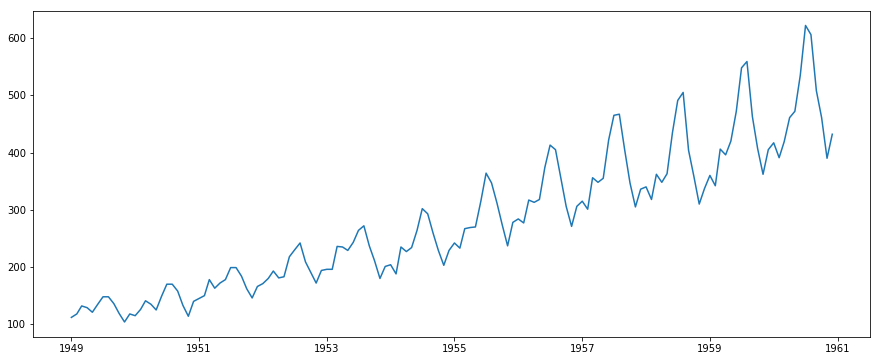

In [72]:
## Checking stationarity of a timeseries
## A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time
## Constant statistical properties over time, ie. the following:
## 1 Constant mean
## 2 Constant variance
## 3 Autocovariance that does not depend on time

plt.plot(ts)